In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

# Decision Trees and Random Forests
*&copy; The Data Incubator*

## Decision Trees

A decision tree is a binary tree.  At each of the internal nodes, it chooses a feature $i$ and a threshold $t$.  Each leaf has a value.  Evaluation of the model is just traversal of the tree from the root.  At each node, we go down the left branch if $X_{ji} \le t$ and the right branch otherwise.  The value of the model $f(X_{ji})$ is the value at the value at the terminating leaf of this traversal.  Below, we show a picture of this on small decision tree trained on the iris data set.  Notice that each internal node has a decision criterion and each leaf has the breakdown of label classes left at this leaf of the tree.  For a geometric picture of a decision tree, take a look at this [blog post](https://shapeofdata.wordpress.com/2013/07/02/decision-trees/).

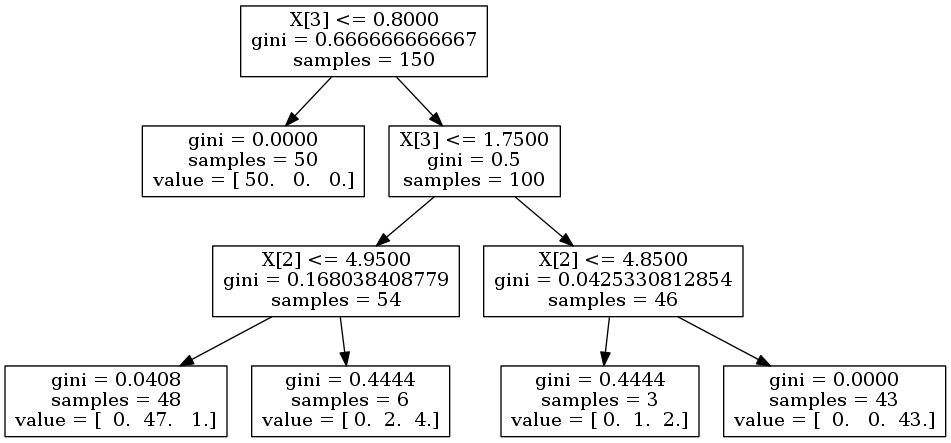

In [2]:
# Train and draw out a decision tree

from IPython import display
from sklearn import datasets, tree, utils
from sklearn.externals.six import StringIO  
import pydot 

# Train a small decision tree on the iris dataset
dataset = datasets.load_iris()
X_iris, y_iris = utils.shuffle(dataset.data, dataset.target, random_state=42)
tree_clf = tree.DecisionTreeClassifier(max_depth=3).fit(X_iris, y_iris)

# Generate a plot of the decision tree
dot_data = StringIO() 
tree.export_graphviz(tree_clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
display.Image(graph.create_png())

The goal of is to find a tree that minimizes some error function.  For classification trees, this is often the *Gini index*:

$$ G = \sum_k p_{mk} (1 - p_{mk})\, , $$

where $p_{mk}$ is the fraction of training observations in region $m$ from class $k$.  The Gini index is quite similar to the cross-entropy

$$ H = - \sum_k p_{mk} \log p_{mk} \, .$$

Both the Gini index and the cross-entropy are minimized by *pure* nodes&mdash;those that contain only a single class.  Regression trees typically minimize the mean squared error.

## Tuning hyperparameters to adjust bias and variance

Considering all possible trees at once would be too computationally intense, so the algorithm to construct a Decision Tree recursively builds a tree structure with a greedy algorithm.  At each node, it finds the split (the feature and threshold level) that maximize the improvement in a criteria (in this case, the decrease in the Gini index).  This algorithm is controlled by four major parameters:

<table>
	<tr>
    <th>Feature</th>
    <th>Value</th>
	</tr>

	<tr>
    <td>`max_features`</td>
    <td>The number of features to consider when choosing a split for an internal node</td>
	</tr>

	<tr>
    <td>`max_depth`</td>
    <td>The maximum depth of tree from the root</td>
	</tr>

	<tr>
    <td>`min_samples_split`</td>
    <td>Minimum number of samples required for a split to be considered</td>
	</tr>

	<tr>
    <td>`min_samples_leaf`</td>
    <td>Minimum number of samples required for each leaf</td>
	</tr>
</table>

**Question**: 

1. How do each of these features affect the Variance Bias Decomposition?
1. The following snippet trains a very basic Decision Tree on the Boston housing price dataset with default parameters.  Adjust the above parameters to tune a better decision tree.  How much better is it's performance?  Hint: use `sklearn.grid_search.GridSearchCV`

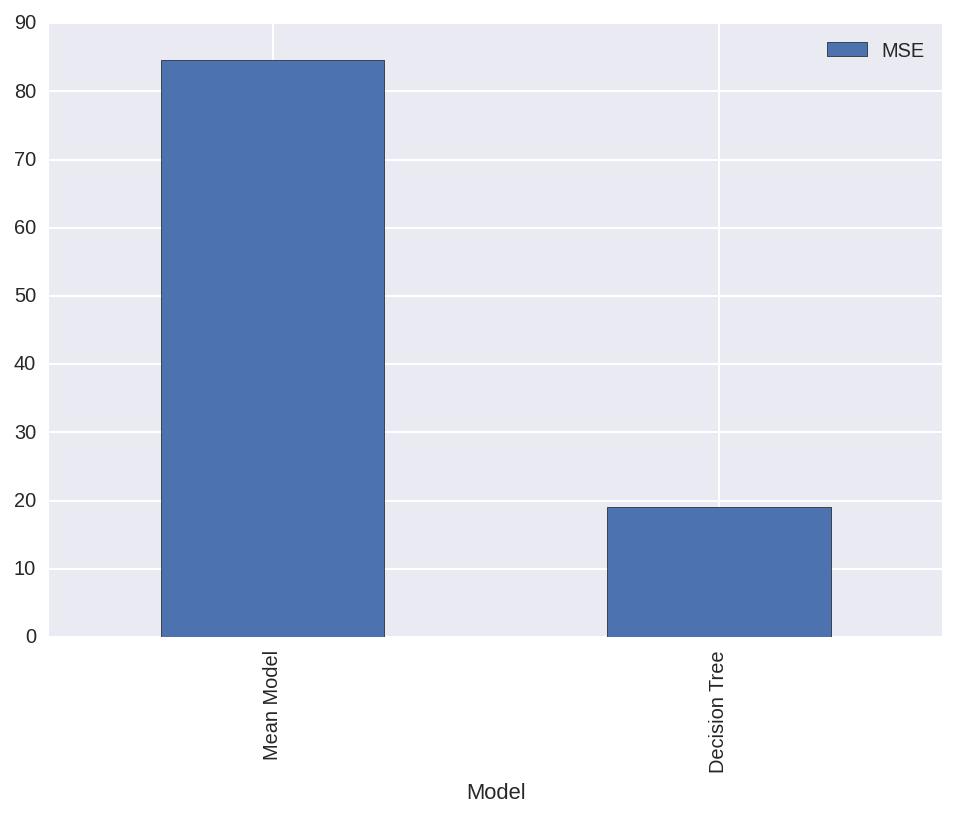

In [3]:
# Train a basic decision tree.  Can you do better?
from sklearn import cross_validation
import pandas as pd

boston = datasets.load_boston()

columns = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSAT"]
X = pd.DataFrame(boston.data, columns=columns)
y = pd.Series(boston.target)

cv = cross_validation.ShuffleSplit(len(y), n_iter=20, test_size=0.2, random_state=42)
def compute_error(clf, X, y):
    return - cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='mean_squared_error').mean()

tree_reg = tree.DecisionTreeRegressor()
pd.DataFrame([
    ("Mean Model", y.var()),
    ("Decision Tree", compute_error(tree_reg, X, y))
], columns=["Model", "MSE"]).plot(x="Model", y="MSE", kind="Bar")

## Random Forests

A random forest is just an ensemble of decision trees.  The predicted value is just the average of the trees (for both regression and classification problems - for classification problems, it is the probabilities that are averaged).  You can adjust `n_estimators` to change the number of trees in the forest.  If each tree is trained on the same subset of data, why aren't they identical?  Two reasons:
1. **Subsampling**: each tree is actually trained on a random selected (with replacement) subset (i.e. bootstrap)
1. **Maximum Features**: the optimal split comes from a randomly selected subset of the features.  In scikit-learn, this feature is controlled by `max_features`.


## Extremely Random Forests
Instead of choosing the optimal split amongst a (randomly selected) subset of features, we choose random values we choose amongst randomly generated thresholds.  While the first two are options in scikit, this is implemented in `ExtraTreesClassifier`.

**Question**: What happens to bias and variance of the individual trees in the averaging process of Random Forests and Extremely Random Forests.  How would you change your parameters to compensate?

You can read more about these [here](http://scikit-learn.org/stable/modules/ensemble.html).

## Tuning hyperparameters

A Random Forest and Extremely Random Forest are pretty straightforward to train once you know how a Decision Tree works.  In fact, their construction can even be parallelized.  They have an extra parameter `n_estimators` and their construction can be parallelized by setting the parameter `n_jobs`.

**Exercise**: the following code trains a random forest and an extra random forest with default parameters.  Can you do better?

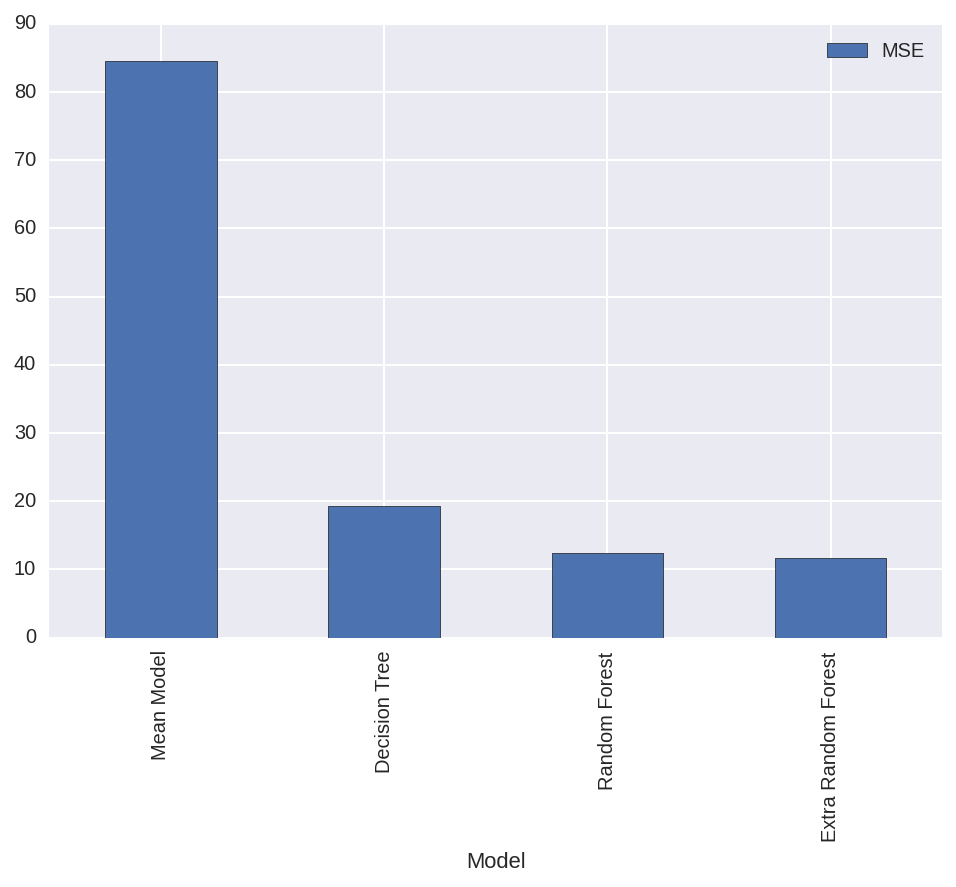

In [4]:
# Train random forests with default parameters.  Can you do better?
from sklearn import cross_validation, ensemble
import pandas as pd

tree_reg = tree.DecisionTreeRegressor()
extra_reg = ensemble.ExtraTreesRegressor()
forest_reg = ensemble.RandomForestRegressor()

model_performance = pd.DataFrame([
    ("Mean Model", y.var()),
    ("Decision Tree", compute_error(tree_reg, X, y)),
    ("Random Forest", compute_error(forest_reg, X, y)),
    ("Extra Random Forest", compute_error(extra_reg, X, y)),
], columns=["Model", "MSE"])
model_performance.plot(x="Model", y="MSE", kind="Bar")

## Gradient Boosting Trees

### Summary:
Gradient Boosting algorithms train on the residual error.  It does this by iteratively training a sequence of models $f_m$ which are based on the residual error from the previous model.  Each one is reducing the residual error left from the previous prediction.  If we have a model prediction $f_{m-1}(X_{j \cdot})$ meant to predictvalue $y_j$, then the next model $f_m$ should train on

$$ y'_j = y_j - f_{m-1}(X_{j \cdot})\,.$$

### Details:
The basic model can be written as

$$ f(X) = f_m(X) = \sum_{k=1}^m \gamma_m h_m(x) $$

where $h_m$ are called **weak learners**.  For Gradient Boosting Trees, the $h_m$ are a collection of stump trees (very short trees, often of height 1).  At each iteration, we estimate everything in two steps:

$$ h_m = \mbox{argmin}_{\gamma, h} \sum_{i=1}^n \left[ - \partial_f L(y_i, f_{m-1}(X_{i \cdot})) - \gamma h(X_{i \cdot}) \right]^2 $$

where $L(y, f(X))$ is the loss function we are trying to minimize.  In words, we compute the negative gradient $- \partial_f L(y_i, f_{m-1}(X_{i \cdot}))$ and then find the values of $\gamma$ and $h$ such that $\gamma h(X_{i \cdot})$ best approximates it (approximate in the sense of $L^2$ norm).  We throw away $\gamma$ and keep $h$ as $h_m$.  Remember that there are a finite collection of $h_m$ and once $h_m$ is set, the solution to $\gamma$ is closed-form becasue of the quadratic form of the potential.

We then set $\gamma_m$ by a one-dimensional linear search of the true loss function with our new $h_m$

$$ \gamma_m = \mbox{argmin}_{\gamma} \sum_{i=1}^n L(y_i, f_{m-1}(X_{i \cdot} + \gamma h_m(X_{i \cdot})) $$

We can then set

$$ f_m(x) = f_{m-1}(x) + \gamma_m h_m(x) $$

as our new predictor and iterate on the residuals.  There are a few basic variants that are usually applied

1.  **Learning Rate**: we usually reduce the learning rate $\alpha$ by choosing a value $0 < \alpha < 1$ such that

    $$ f_m(x) = f_{m-1}(x) + \alpha \gamma_m h_m(x) $$

    Setting $\alpha = 1$ would yield the model present above.  This slows down the rate at which we learn.
1.  **Subsampling**: we can learn on a fraction of the data which is a subsample of the full dataset.
1.  **Max Features**: we can learn from only a subset of the features (i.e. trees only select a subset of the features).
1.  **Trying out different loss fucntions**: We can choose different functional forms $L$.

You can learn more about gradient boosting [here](http://scikit-learn.org/stable/modules/ensemble.html).

**Question**: 

1. How do these techniques affect the bias and variance of the learned models?
2. The following code trains a gradient boosting tree with some chosen parameters.  Can you do better?

In [5]:
# GradientBoostingRegressor
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.02, 'loss': 'ls'}

gradient_reg = ensemble.GradientBoostingRegressor(**params)

gradient_performance = pd.DataFrame([
    ("Gradient Boosted Regressor", compute_error(gradient_reg, X, y))
], columns=["Model", "MSE"])

In [6]:
X.shape

(506, 13)

In [ ]:
model_performance.append(gradient_performance).plot(x="Model", y="MSE", kind="Bar")

## Determining feature importance

With a linear regression, we could inspect the coefficients to tell which terms were the most important.  With decision trees and random forests, the model structure is much more opaque.  Fortunately, all of these models (once trained) have an array called `feature_importances_` which gives the imporances of all the features.  How do they compute feature importance?  According to the [scikit documentation](http://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation):

> The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree are used contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features.

Let's show this in action.  For scikit, larger values are more important and the values of `feature_importances_` sum to 1:

In [ ]:
pd.DataFrame([
    tree_reg.fit(X, y).feature_importances_,
    forest_reg.fit(X, y).feature_importances_,
    extra_reg.fit(X, y).feature_importances_,
    gradient_reg.fit(X, y).feature_importances_
], columns=columns, index=["Tree", "Forest", "Extra Random", "Gradient"]).T.plot(kind="bar").legend(loc="upper left")

### Questions
What is the tradeoff between Decision Trees, Random Forests, and Gradient Boosting Trees, in terms of explicability, computational time, memory, and accuracy?

### Exit Tickets
1. What attribute(s) of decision trees enable them to be chained together into gradient boosting trees?
1. Which is more computationally intensive? Training or testing?
1. Can a random forest model be trained online?

### Spoilers

### Answers

### Decision Trees
1. Increasing `max_features` and `max_depth` and decreasing `min_samples_split` and `min_samples_leaf` tend to build more complex models (increase Variance and reduce Bias).
1. Straightfoward.

### Random Forests
The variance between different trees tends to cancel each other while the biases reinforce each other.  That is, becasue the trees are different, they tend to overfit in different ways but when they underfit, they underfit the same way.  So you want to use higher variance, lower bias parameters than you would with a decision tree.

### Gradient Boosting Trees
Increasing the learning rate increases variance.  Decreasing the fraction subsampled and the max features will decrease the variance.le

### Final Question
Decision Trees are clearly the least accurate although possibly the most explicable and they train quickly.  (Extra) Random Forests are more expensive to train but can be trained in parallel -- both across processors on the same data in one machine and across machines by splitting up the sample data.  Gradient Boosting Trees are not as naturally parallelizable and (empirically) seem to be the slowest. [Algorithm comparison notebook](Comparing_ML_Algorithms.ipynb)

*Copyright &copy; 2015 The Data Incubator.  All rights reserved.*